**Importing Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
import torch
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
from sklearn.metrics import accuracy_score

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv("../input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv")
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
df.shape

(162980, 2)

In [5]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df['category'] = df['category'].map({
    -1.0: "Negative",
    1.0: "Positive",
    0.0: "Neutral"
})

df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


In [8]:
frequencyOfSentiment = df.groupby("category").count()

frequencyOfSentiment

,clean_text
category,
Negative,35509
Neutral,55211
Positive,72249


In [9]:
frequencyOfSentiment["clean_text"].values

array([35509, 55211, 72249])

In [10]:
frequencyOfSentiment.index

Index(['Negative', 'Neutral', 'Positive'], dtype='object', name='category')

<BarContainer object of 3 artists>

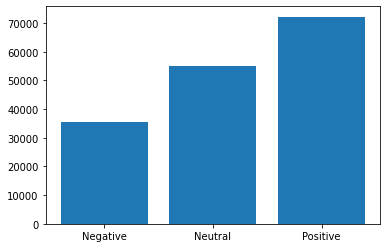

In [11]:
plt.bar(frequencyOfSentiment.index, frequencyOfSentiment["clean_text"].values)

In [12]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function : preprocessing

* parameter(s) = A single text row from the dataframe
* returns = the same text but cleaned up

In [13]:
def preprocessing(text):
  text = text.lower()
  text = re.sub(r"[^a-zA-Z0-9]", " ", text)
  tokenizedText = word_tokenize(text)
  tokenizedText = [stemmer.stem(word) for word in tokenizedText if word not in stop_words]
  return tokenizedText

In [14]:
sentence = df['clean_text'][0]

sentence

'when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples'

In [15]:
preprocessing(sentence)

['modi',
 'promis',
 'minimum',
 'govern',
 'maximum',
 'govern',
 'expect',
 'begin',
 'difficult',
 'job',
 'reform',
 'state',
 'take',
 'year',
 'get',
 'justic',
 'state',
 'busi',
 'exit',
 'psu',
 'templ']

In [16]:
X = list(map(preprocessing, df['clean_text']))

X[0]

['modi',
 'promis',
 'minimum',
 'govern',
 'maximum',
 'govern',
 'expect',
 'begin',
 'difficult',
 'job',
 'reform',
 'state',
 'take',
 'year',
 'get',
 'justic',
 'state',
 'busi',
 'exit',
 'psu',
 'templ']

In [17]:
encoder = LabelEncoder()

Y = encoder.fit_transform(df["category"])

print(df["category"].values[:5], Y[:5])

['Negative' 'Neutral' 'Positive' 'Positive' 'Positive'] [0 1 2 2 2]


# Function : label_encoding

* parameter(s) = List of cleaned up sentences
* returns = unique words mapped with corrosponding number

In [18]:
def label_encoding(X):
  vocabularySet = set()
  for text in X:
    for word in text:
      vocabularySet.add(word)

  counter = 1
  mapper = {}
  for word in vocabularySet:
    mapper[word] = counter
    counter += 1

  return mapper

In [19]:
mapper = label_encoding(X)

# Function : apply_encoding

* parameter(s) = mapped unique words , list of cleaned up text
* returns = list of cleaned up text but encoded with the numbers from mapper

In [20]:
def apply_encoding(mapper, X):
  encodedX = []
  for review in X:
    temp = []
    for word in review:
      temp.append(mapper[word])
    encodedX.append(temp)

  return encodedX

In [21]:
X = apply_encoding(mapper, X)

# Function : max_len

* parameter(s) = list of cleaned up encoded text
* returns = Max length of a text from the list

In [22]:
def max_len(X):
  maximumLengthText = 0
  for text in X:
    maximumLengthText = max(maximumLengthText, len(text))
  return maximumLengthText

max_len(X)

43

# Function : list_tensor

* parameter(s) = list of cleaned up encoded text
* returns = list of cleaned up encoded text but as a tensor now

In [23]:
def list_tensor(X):
  tensorX = []
  for text in X:
    tensorX.append(torch.Tensor(text))

  return tensorX

In [24]:
X_tensor = list_tensor(X)

X_tensor[0]

tensor([33989., 37824., 60150., 25053., 42885., 25053., 53357.,  9571., 60268.,
        44062., 79762., 36373.,   810., 74827., 32876., 11159., 36373., 52176.,
        19639., 20186., 84691.])

In [25]:
new_X = pad_sequence(X_tensor, batch_first=True)

In [26]:
new_X[0]

tensor([33989., 37824., 60150., 25053., 42885., 25053., 53357.,  9571., 60268.,
        44062., 79762., 36373.,   810., 74827., 32876., 11159., 36373., 52176.,
        19639., 20186., 84691.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.])

In [27]:
Y_array = np.array(Y)

In [28]:
X_array = np.array(new_X, dtype="int32")

In [29]:
X_array[0]

array([33989, 37824, 60150, 25053, 42885, 25053, 53357,  9571, 60268,
       44062, 79762, 36373,   810, 74827, 32876, 11159, 36373, 52176,
       19639, 20186, 84691,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X_array, Y_array, test_size=0.2, random_state=0)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape 

((130375, 43), (130375,), (32594, 43), (32594,))

In [31]:
vocab_size = len(mapper)
vocab_size += 1

vocab_size

87935

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
print(device)

cuda


### LSTM

In [34]:
torch.cuda.empty_cache()

# **Class : LSTM**

**Variables :-**

* hidden_size : Number of features in the hidden state
* embedding : Embedding table storing the embeddings of the whole vocabulary and is easily accessible
* lstm : Layer where sequences are sent and output is taken from
* linear : transforming the output from lstm into linear output
* dropout : Reducing overfitting by zeroing some values randomly

**Functions :-**

* __ init __ : Initialization function
* forward : Function which executes a single forward pass

In [35]:
class LSTM(nn.Module):
  
  def __init__(self, vocab_size):
    super().__init__()
    self.hidden_size = 64
    self.embedding = nn.Embedding(vocab_size, 32)
    self.lstm = nn.LSTM(32, self.hidden_size, 1, batch_first=True,bidirectional=False) # 1 :- no. of layers
    self.linear = nn.Linear(self.hidden_size, 3)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    batch_size = x.shape[0]

    x_embedding = self.embedding(x)
    
    h0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
    
    out, hidden_state = self.lstm(x_embedding, (h0, c0))
    
    last_output = out[:, -1, :]
    
    last_out = self.dropout(last_output)
    
    final_output = self.linear(last_output)
    
    return final_output

In [36]:
def trainingTesting(model, optimizer, loss_function, n_epochs, X, Y,X_test,Y_test):
  for epoch in range(n_epochs):

    batch_size = 128
    size = X.shape[0]

    for i in range(0, size, batch_size):
      
      start = i
      end = i + batch_size
      end = min(size, end)

      X_batch = X[start:end]
      Y_batch = Y[start:end]

      prediction = model.forward(X_batch)

      loss = loss_function(prediction, Y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    if (epoch+1)%5==0:
        with torch.no_grad():
          prediction = model.forward(X)
          Y_pred = torch.argmax(prediction, dim=1)
          Y_pred_cpu = Y_pred.cpu().numpy()
          Y_actual_cpu = Y.cpu().numpy()
          print(f"Epoch {epoch+1}:- Accuracy: {accuracy_score(Y_actual_cpu, Y_pred_cpu)*100}")
          prediction = model.forward(X_test)
          Y_pred = torch.argmax(prediction, dim=1)
          Y_pred_cpu = Y_pred.cpu().numpy()
          Y_actual_cpu = Y_test.cpu().numpy()
          print(f"Testing Accuracy: {accuracy_score(Y_actual_cpu, Y_pred_cpu)*100}")

In [37]:
lstm_model = LSTM(vocab_size).to(device)

In [38]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0001)

In [39]:
Y_tensor = torch.tensor(Y_train).to(device)

X_tensor = torch.tensor(X_train, dtype=torch.int32).to(device)
Y_test_tensor = torch.tensor(Y_test).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.int32).to(device)

trainingTesting(lstm_model, optimizer, loss_function, 100, X_tensor, Y_tensor,X_test_tensor,Y_test_tensor)

Epoch 5:- Accuracy: 62.78197507190796
Testing Accuracy: 62.89807940111677
Epoch 10:- Accuracy: 68.17488015340363
Testing Accuracy: 67.13505553169294
Epoch 15:- Accuracy: 72.77315436241611
Testing Accuracy: 70.59888323004235
Epoch 20:- Accuracy: 76.60671140939598
Testing Accuracy: 73.3141068908388
Epoch 25:- Accuracy: 79.92253116011506
Testing Accuracy: 75.84831564091552
Epoch 30:- Accuracy: 82.32099712368168
Testing Accuracy: 77.65539669877892
Epoch 35:- Accuracy: 84.05139022051775
Testing Accuracy: 78.6126280910597
Epoch 40:- Accuracy: 85.1489932885906
Testing Accuracy: 78.88875253114071
Epoch 45:- Accuracy: 85.84467881112177
Testing Accuracy: 79.09737988586856
Epoch 50:- Accuracy: 87.47075743048897
Testing Accuracy: 79.9104129594404
Epoch 55:- Accuracy: 88.29069990412273
Testing Accuracy: 80.11290421549978
Epoch 60:- Accuracy: 88.7294343240652
Testing Accuracy: 80.07301957415476
Epoch 65:- Accuracy: 89.36299137104507
Testing Accuracy: 80.69583358900411
Epoch 70:- Accuracy: 89.6997123